In [55]:
from keras import backend as K
from tensorflow import keras

import numpy as np
import os

from matplotlib import pyplot as plt

from vis.visualization import visualize_activation
from vis.utils import utils

In [2]:
model = keras.models.load_model("models/new_arch/chb02_threshold_0.887_false_neg_0_true_neg_3115_false_pos_364_true_pos_39_accuracy_90_regularised.h5")

In [51]:
ictal_data = np.load("ml_processed_balanced/chb02_16+.edf_data.npy")
ictal_labels = np.load("ml_processed_balanced/chb02_16+.edf_labels.npy")

ictal_true = ictal_data[120]
ictal_false = ictal_data[30]

print(ictal_true.shape)

(23, 256)


In [49]:
filters, bias = model.layers[0].get_weights()
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

print(filters.shape)
print(filters[0])

(5, 256, 512)
[[0.50782686 0.51393783 0.5066458  ... 0.5098257  0.5033143  0.5142426 ]
 [0.5050017  0.5044472  0.49808022 ... 0.51135117 0.4999071  0.5090362 ]
 [0.5110018  0.5115689  0.5035871  ... 0.4978913  0.51428545 0.50206304]
 ...
 [0.50224704 0.50735277 0.51549137 ... 0.5062973  0.5025398  0.5155761 ]
 [0.51142985 0.5087509  0.5100086  ... 0.5140449  0.50805527 0.5137385 ]
 [0.5053742  0.51483476 0.5097854  ... 0.5111557  0.50143677 0.5105279 ]]


c:\Users\angus\Documents\cs408-eeg-python\venv3.7\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  


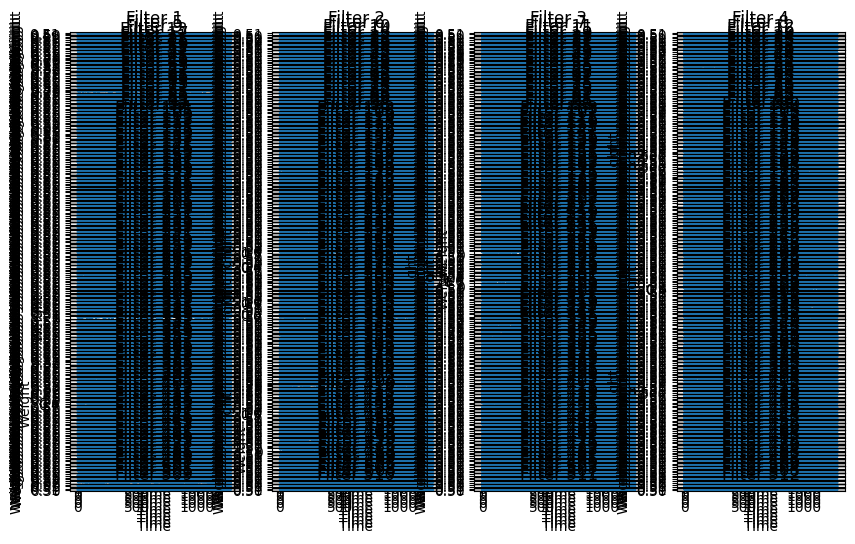

In [50]:
# Number of filters
num_filters = filters.shape[2]

# Plot each filter
plt.figure(figsize=(10, 6))
for i in range(num_filters):
    plt.subplot(num_filters // 4 + 1, 4, i + 1)
    plt.plot(filters[:, :, i].flatten())
    plt.title('Filter {}'.format(i + 1))
    plt.xlabel('Time')
    plt.ylabel('Weight')
    plt.grid(True)

plt.show()

c:\Users\angus\Documents\cs408-eeg-python\venv3.7\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.


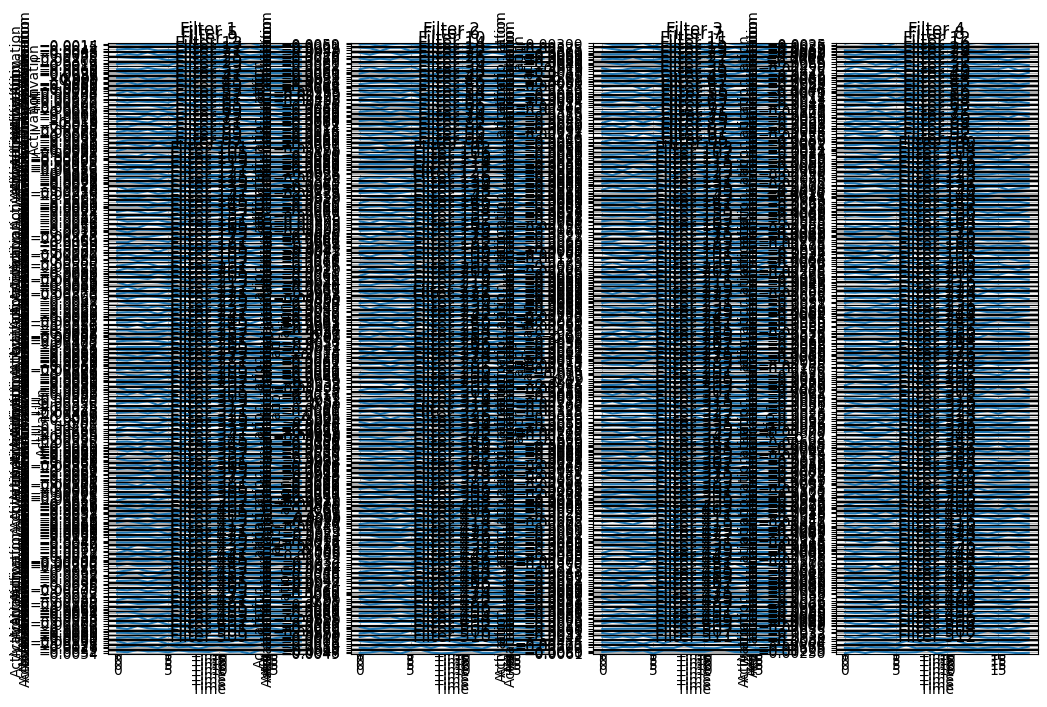

In [56]:
# Function to extract activations from intermediate layers
get_activations = K.function([model.layers[0].input], [model.layers[i].output for i in range(len(model.layers))])

# Get activations for the first convolutional layer
layer_outputs = get_activations([np.expand_dims(ictal_true, axis=0)])[0]  # Assuming first conv layer is index 1

# Plot activation maps
plt.figure(figsize=(12, 8))
num_filters = layer_outputs.shape[-1]
for i in range(num_filters):
    plt.subplot(num_filters // 4 + 1, 4, i + 1)
    plt.plot(layer_outputs[0, :, i])
    plt.title('Filter {}'.format(i + 1))
    plt.xlabel('Time')
    plt.ylabel('Activation')
    plt.grid(True)

plt.tight_layout()
plt.show()

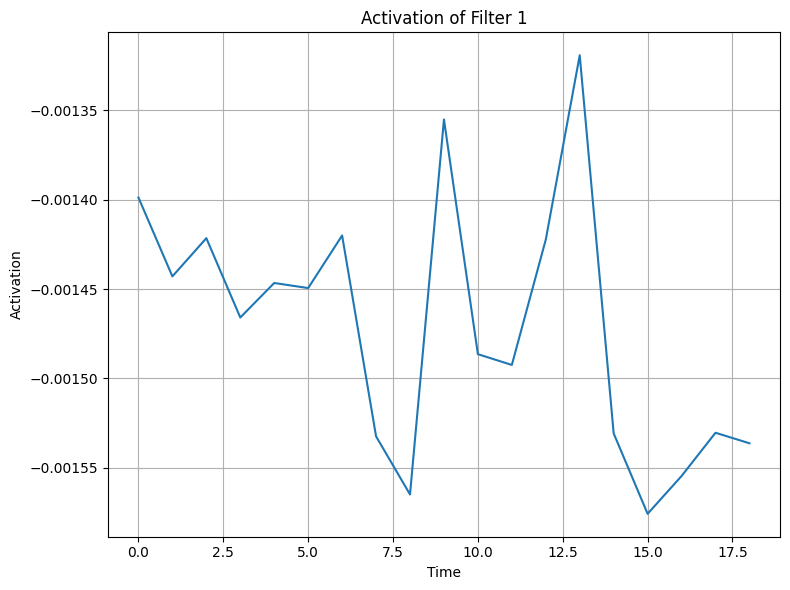

In [57]:
# Plot only one filter and a specific time range
filter_index = 0  # Choose the filter index to plot
time_start = 0   # Choose the starting time index
time_end = 64    # Choose the ending time index

plt.figure(figsize=(8, 6))
plt.plot(layer_outputs[0, time_start:time_end, filter_index])
plt.title('Activation of Filter {}'.format(filter_index + 1))
plt.xlabel('Time')
plt.ylabel('Activation')
plt.grid(True)
plt.tight_layout()
plt.show()

In [79]:
activations = layer_outputs[0, :, filter_index]
print(activations.shape)
print(layer_outputs.shape)

(19,)
(1, 19, 512)


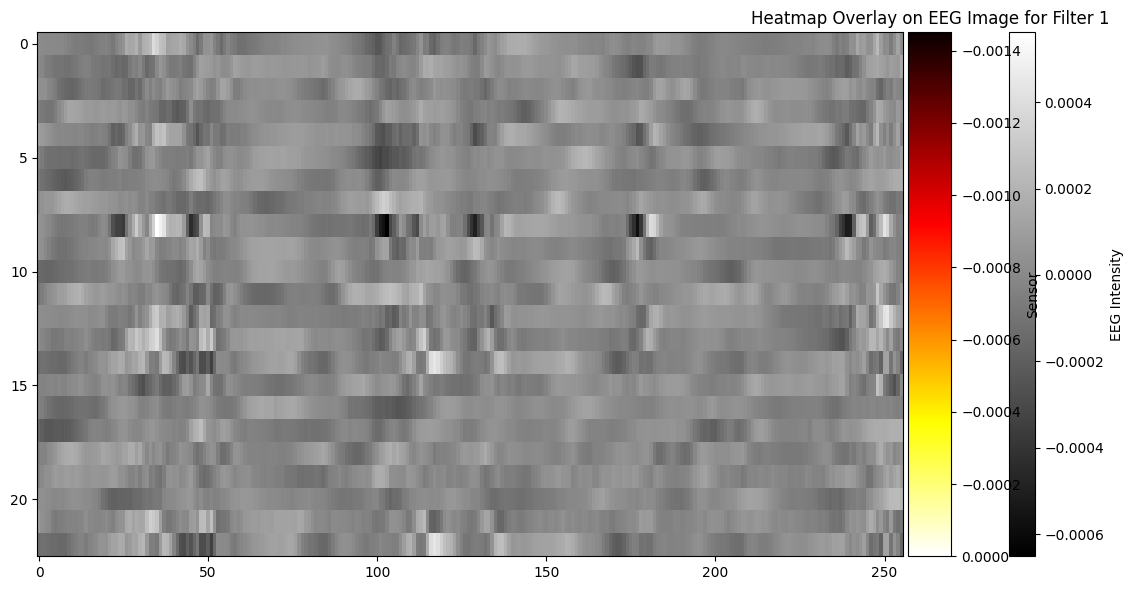

In [59]:
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Plot heatmap overlaid on EEG image for a specific filter
filter_index = 0  # Choose the filter index to visualize
activations = layer_outputs[0, :, filter_index]

# Plot EEG image
plt.figure(figsize=(12, 6))
plt.imshow(ictal_true, cmap='gray', aspect='auto')
plt.colorbar(label='EEG Intensity')

# Plot heatmap overlaid on EEG image
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(plt.imshow(np.expand_dims(activations, axis=0), cmap='hot', aspect='auto', norm=Normalize(vmin=0, vmax=np.max(activations))), cax=cax, label='Filter Activation')

plt.title('Heatmap Overlay on EEG Image for Filter {}'.format(filter_index + 1))
plt.xlabel('Time')
plt.ylabel('Sensor')
plt.tight_layout()
plt.show()

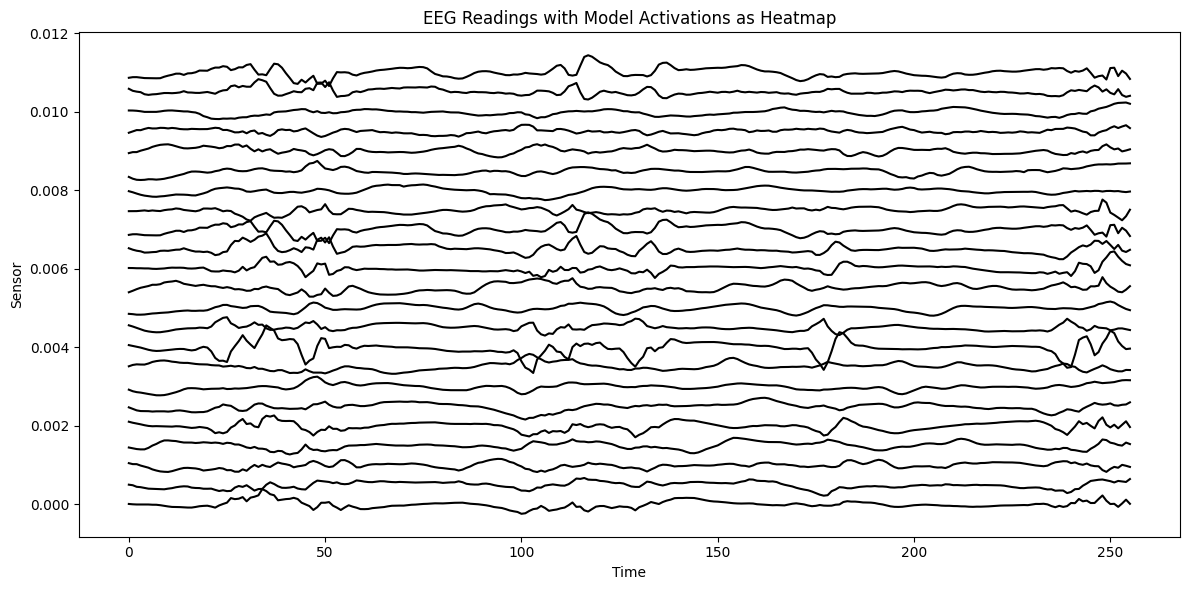

In [77]:
# Plot EEG readings
plt.figure(figsize=(12, 6))
for i in range(ictal_true.shape[0]):
    plt.plot(ictal_true[i] + i * 0.0005, color='black')  # Shift each sensor's data for visualization clarity

# Plot activations as heatmap
for i in range(layer_outputs.shape[-1]):
    activations = layer_outputs[0, :, i]
    plt.plot(activations / np.max(activations) * 0.0005 + i * 0.0005, color='red', alpha=0.7)  # Scale activations for visualization and shift each line

plt.title('EEG Readings with Model Activations as Heatmap')
plt.xlabel('Time')
plt.ylabel('Sensor')
plt.tight_layout()
plt.show()

IndexError: index 19 is out of bounds for axis 0 with size 19

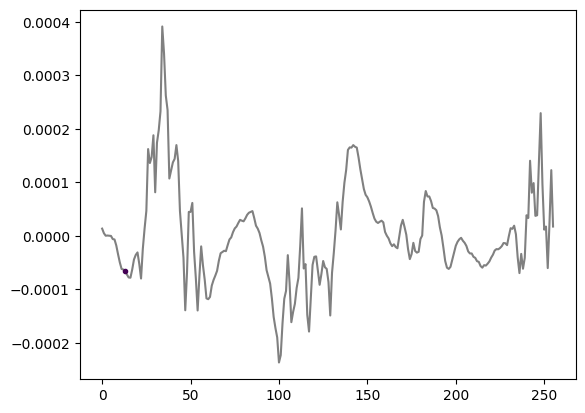

In [80]:
for i in range(23):  # For each EEG sensor
    sensor_data = ictal_true[i]
    plt.plot(sensor_data, color='gray')  # Plot the original EEG data in gray

    # Map the activation strength to a color for each point
    # This requires matching the EEG data resolution with the activation resolution
    # You may need to interpolate activations if they don't match the EEG data's resolution
    # Here, we just assume they match for simplicity

    colors = plt.cm.viridis(activations)  # Using viridis colormap, but you can choose another

    for j in range(len(sensor_data)):
        plt.plot(j, sensor_data[j], '.', color=colors[j])  # Plot each point colored by its activation

plt.show()

In [81]:
from scipy.interpolate import interp1d

activations_avg = np.mean(layer_outputs[0], axis=-1)  # This will have shape (19,)
x_eeg = np.arange(256)  # Target positions matching the EEG data resolution
x_eeg = np.arange(256)  # Target positions matching the EEG data resolution
x_activations = np.linspace(0, 255, num=19)  # Original positions of the activations
interp_func = interp1d(x_activations, activations_avg, kind='linear')

# Interpolated activations to match the EEG data resolution
activations_interpolated = interp_func(x_eeg)

activations_normalized = activations_interpolated / np.max(activations_interpolated)
for i in range(23):  # For each EEG sensor
    plt.figure(figsize=(10, 6))
    sensor_data = ictal_true[i]
    colors = plt.cm.viridis(activations_normalized)  # Color map

    for j, point in enumerate(sensor_data):
        plt.plot(j, point, marker='.', color=colors[j])

    plt.title(f'Sensor {i+1} Activation Mapping')
    plt.xlabel('Time Point')
    plt.ylabel('EEG Signal Amplitude')
    plt.show()

TypeError: descriptor '_y_axis' for '_Interpolator1D' objects doesn't apply to 'interp1d' object

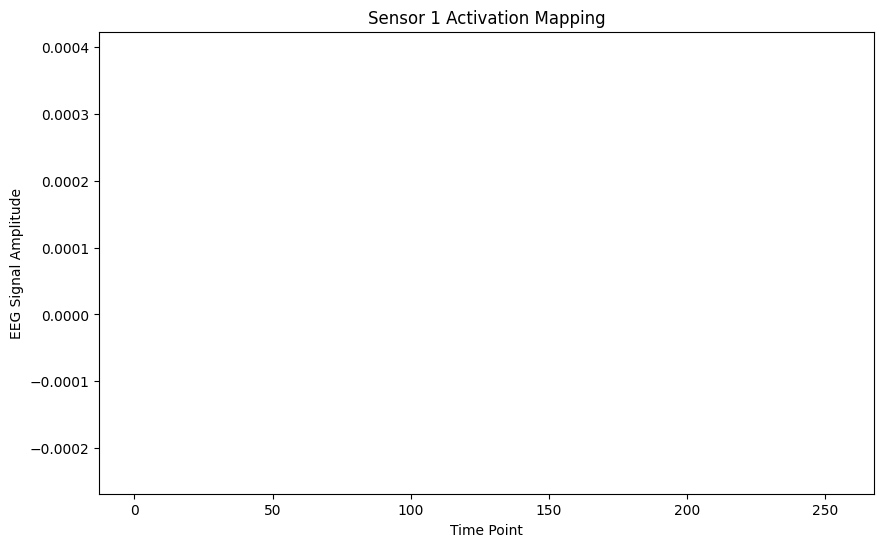

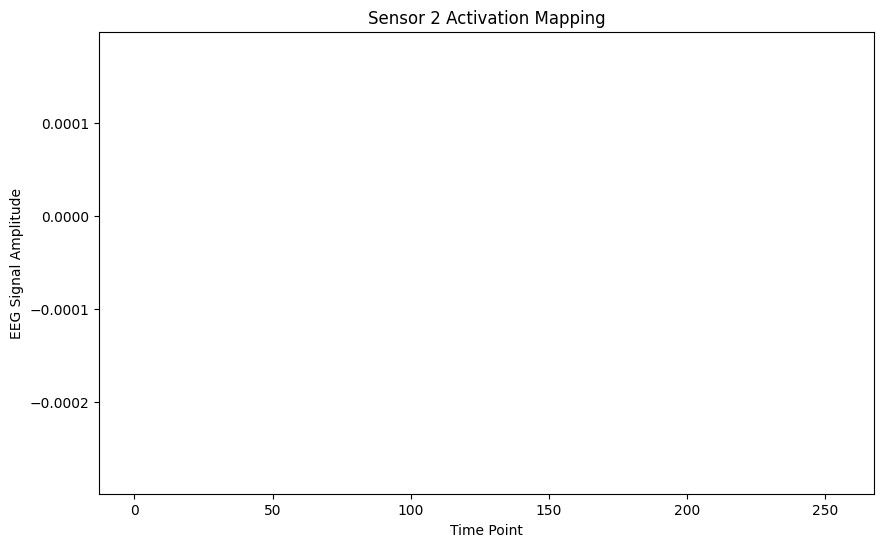

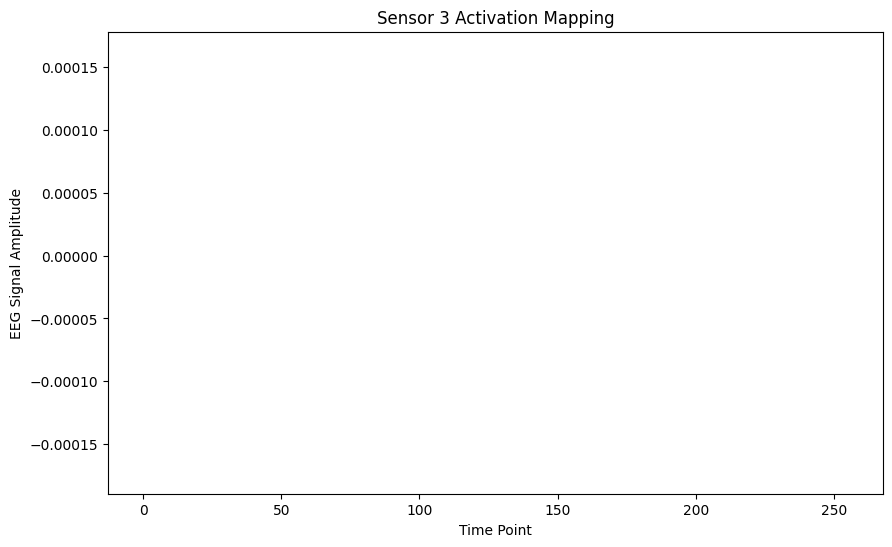

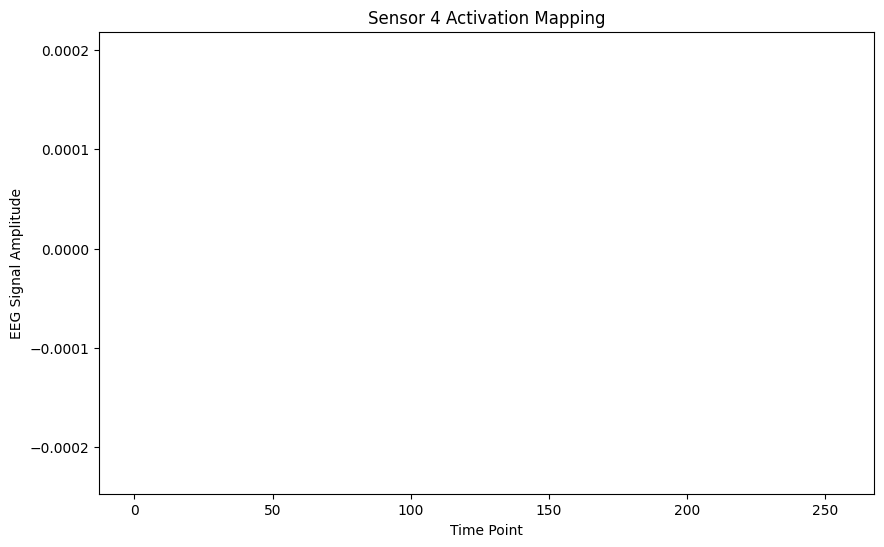

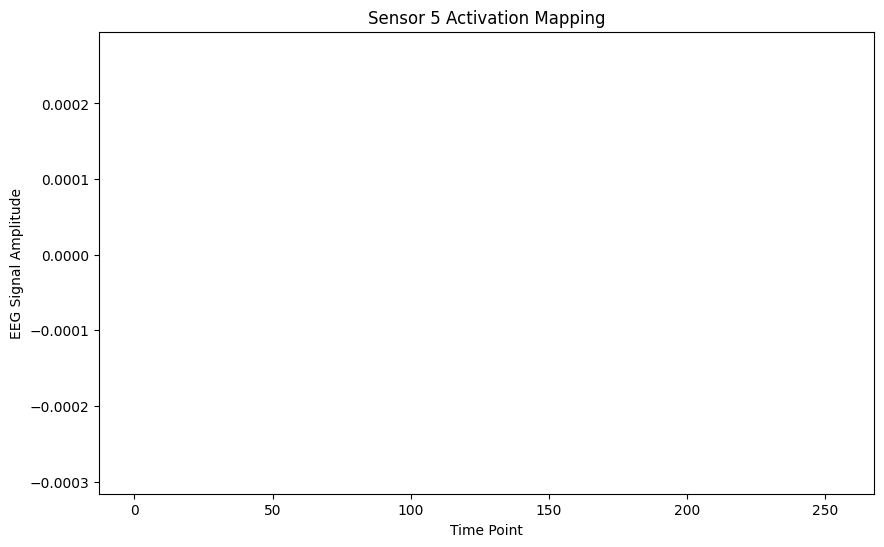

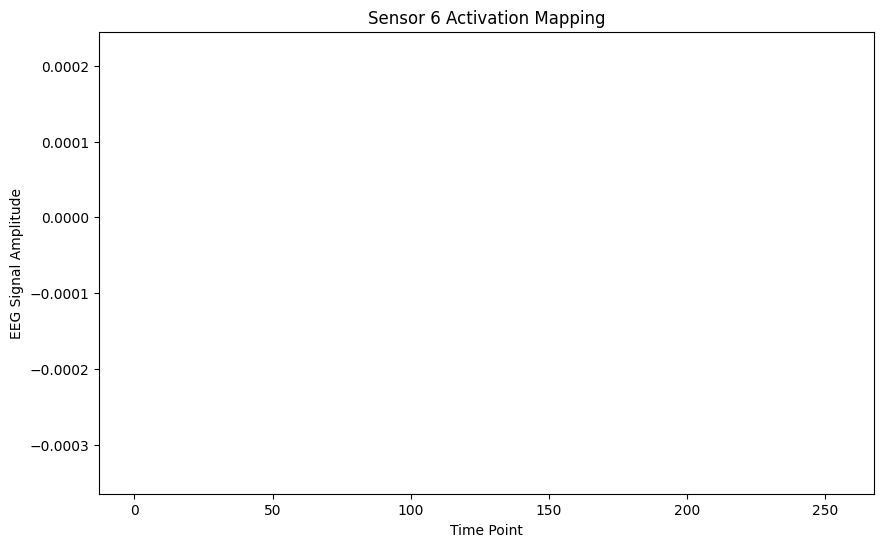

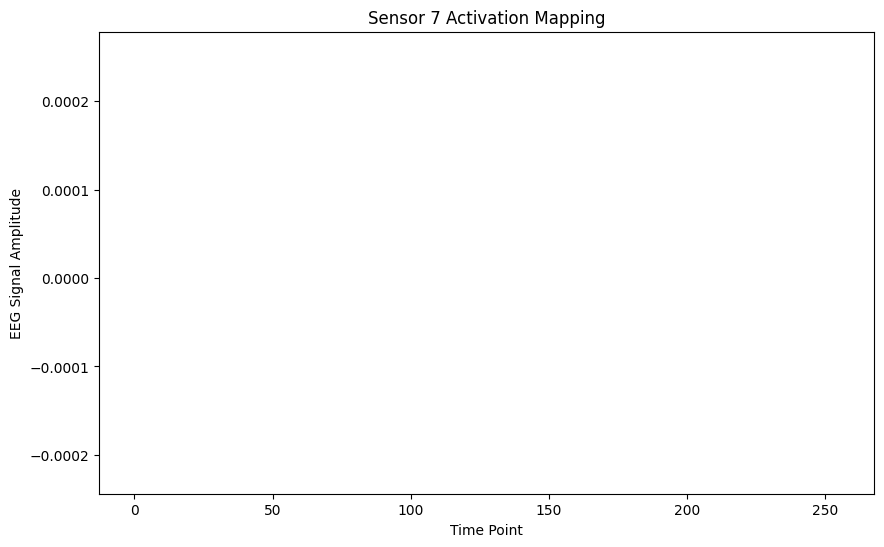

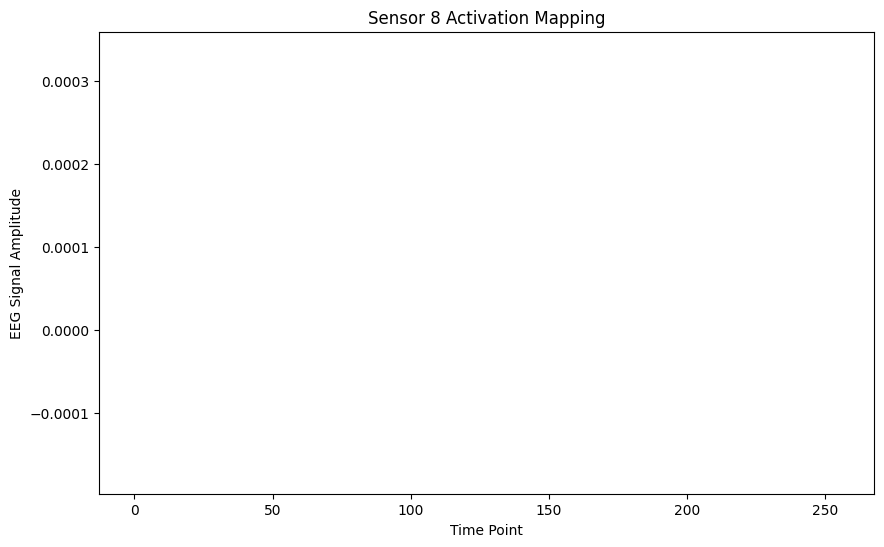

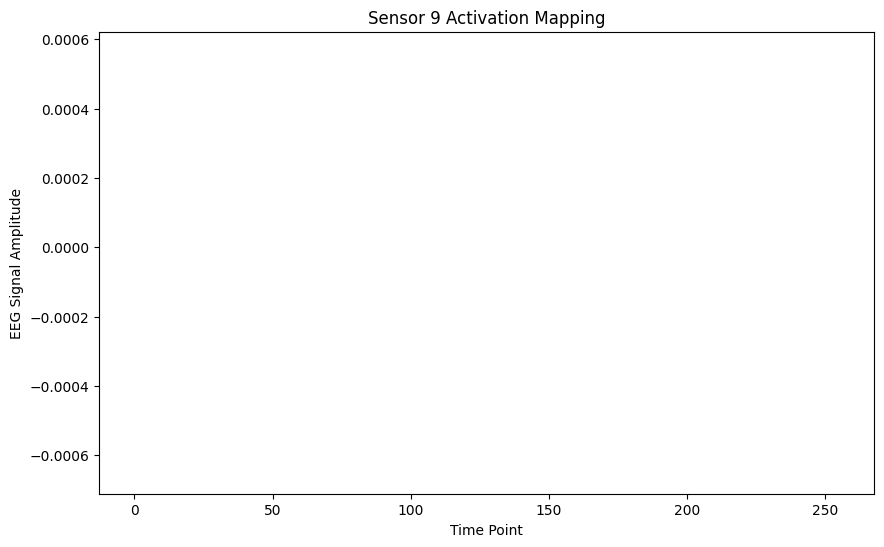

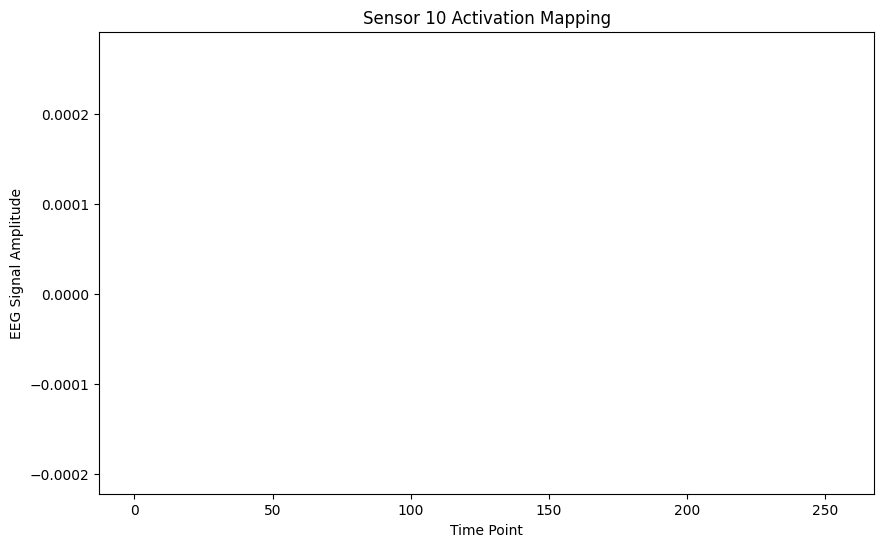

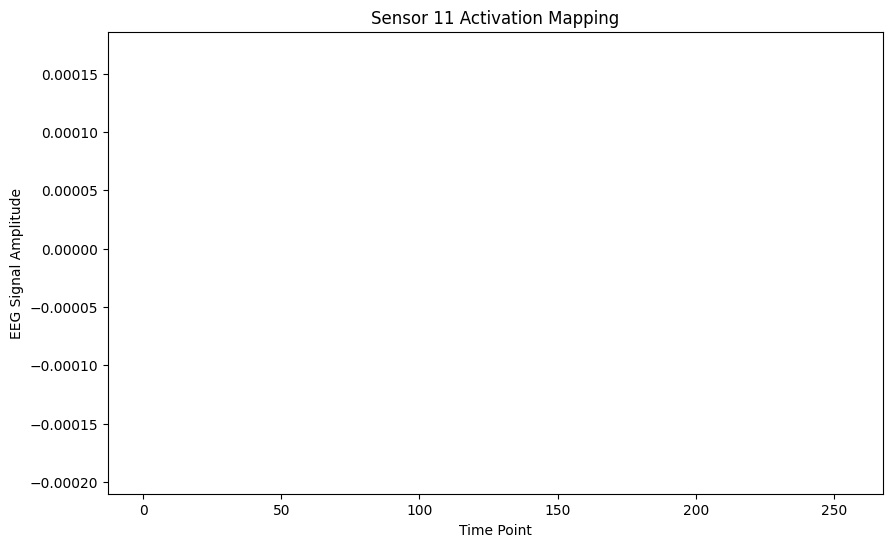

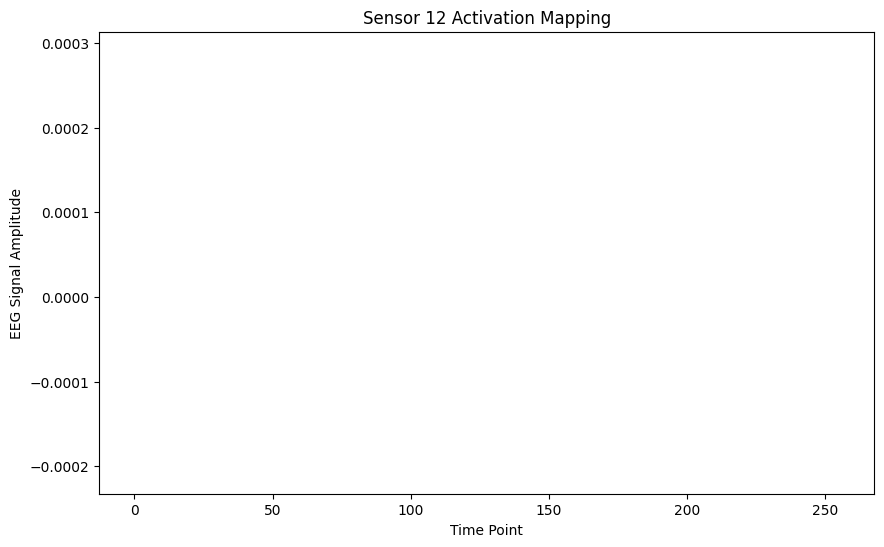

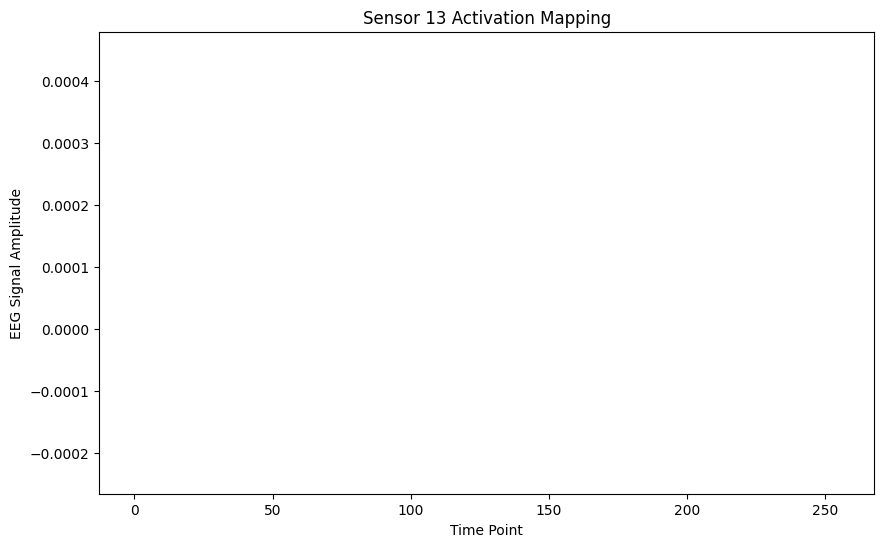

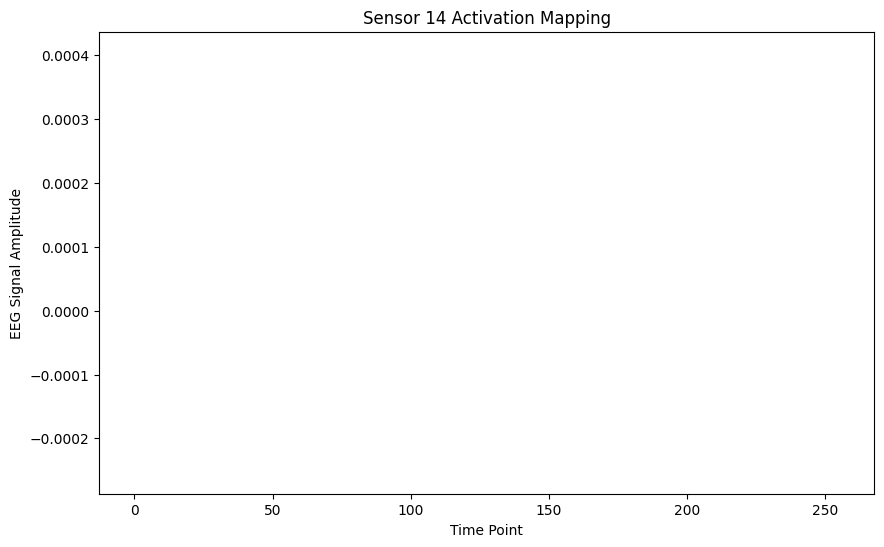

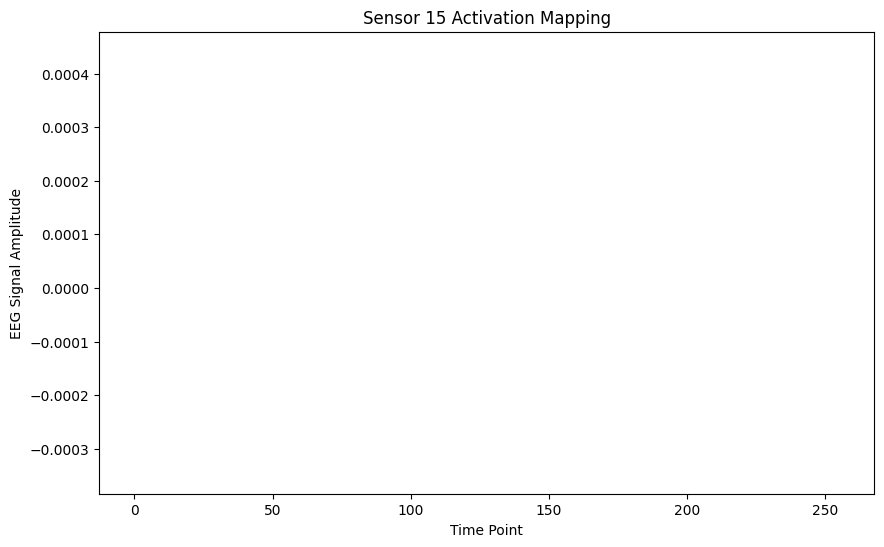

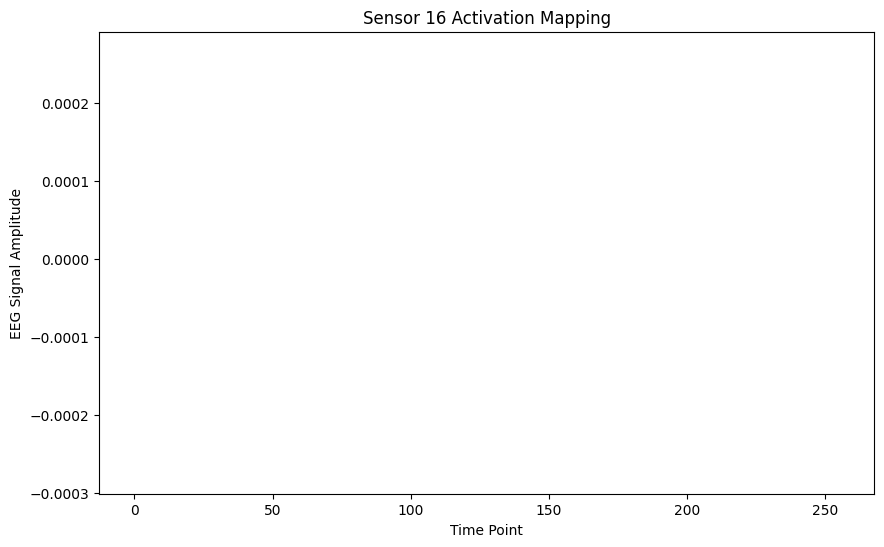

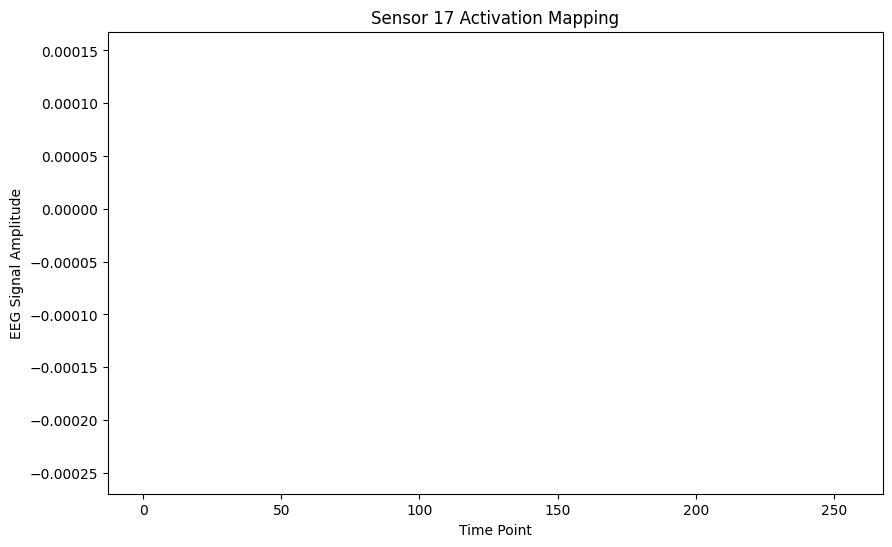

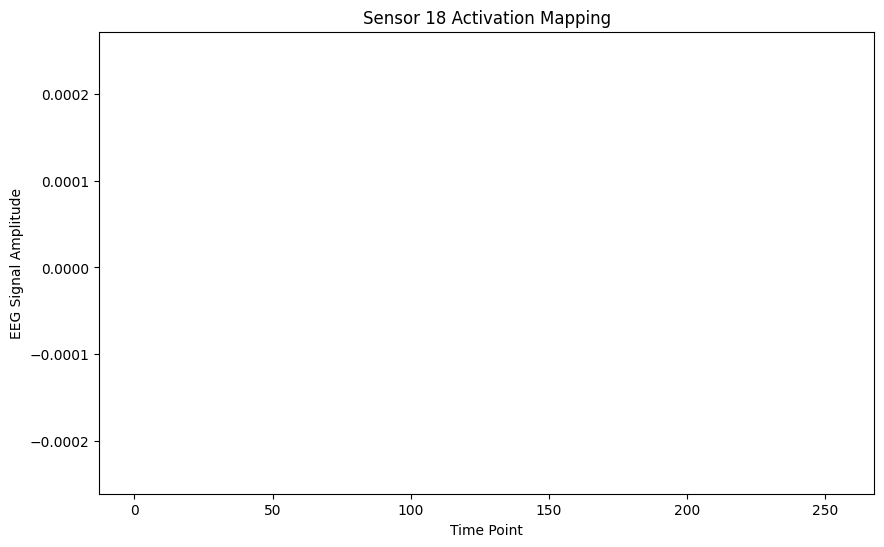

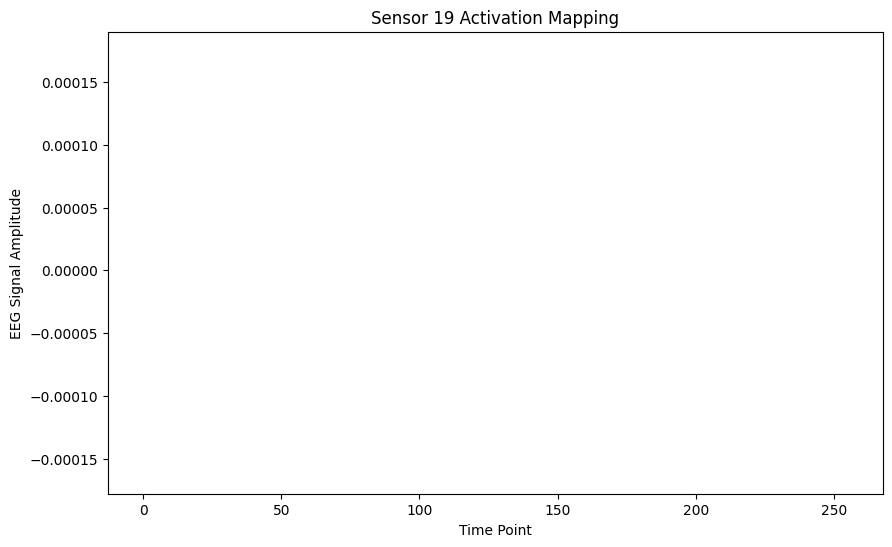

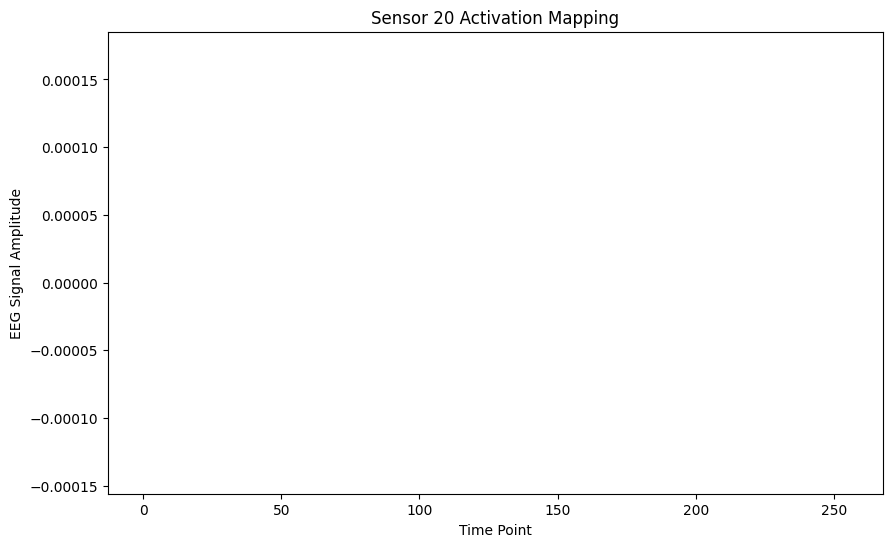

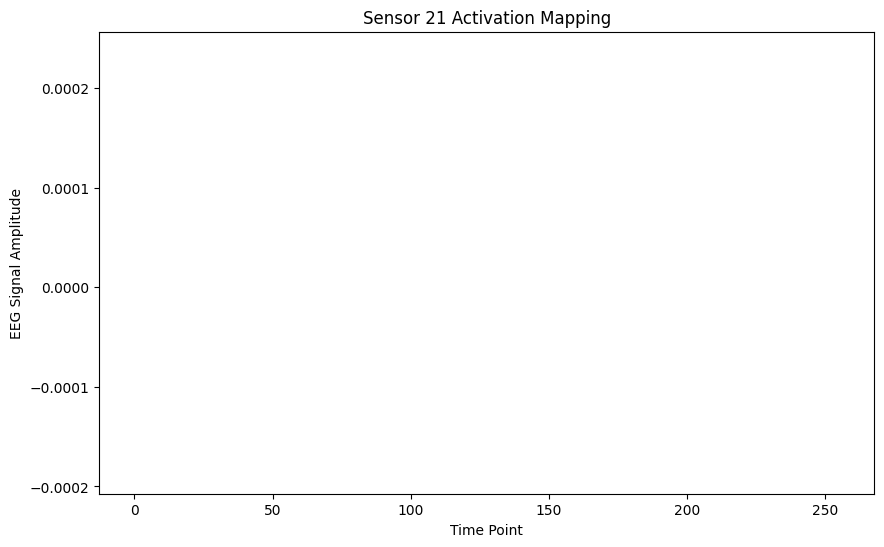

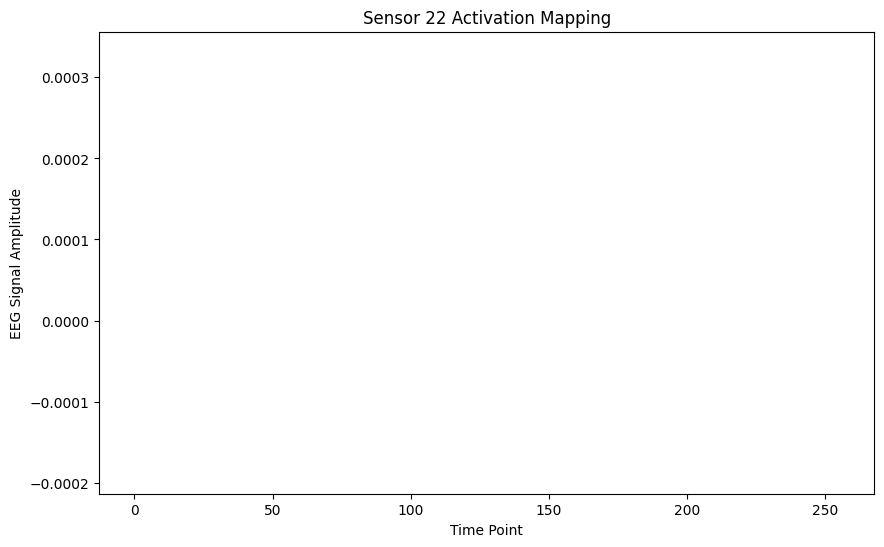

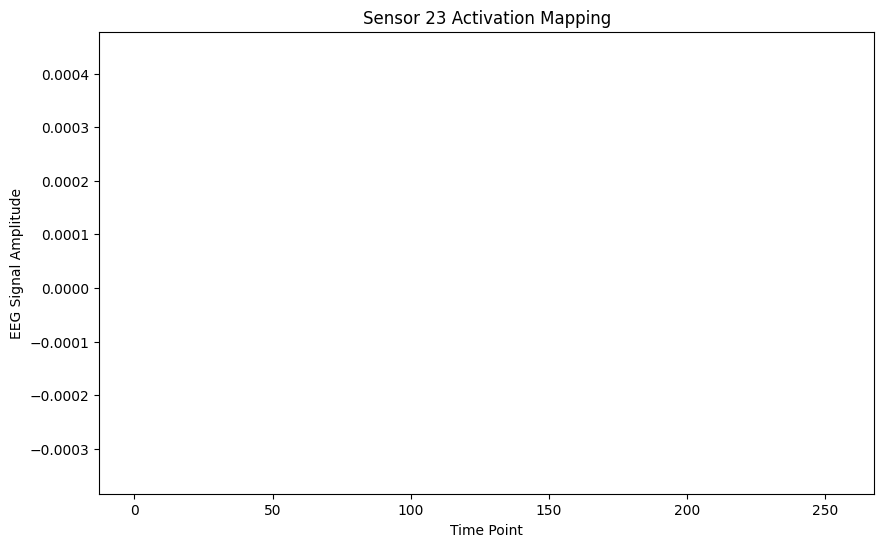

In [82]:
activations_avg = np.mean(layer_outputs[0], axis=-1)  # This will have shape (19,)

# Define original and target positions
x_activations = np.linspace(0, 255, num=19)  # Original positions of the activations
x_eeg = np.arange(256)  # Target positions matching the EEG data resolution

# Use numpy.interp for linear interpolation
activations_interpolated = np.interp(x_eeg, x_activations, activations_avg)

# Normalize the interpolated activations for color mapping
activations_normalized = activations_interpolated / np.max(activations_interpolated)

# Plotting
for i in range(23):  # For each EEG sensor
    plt.figure(figsize=(10, 6))
    sensor_data = ictal_true[i]
    colors = plt.cm.viridis(activations_normalized)  # Color map

    for j, point in enumerate(sensor_data):
        plt.plot(j, point, marker='.', color=colors[j])

    plt.title(f'Sensor {i+1} Activation Mapping')
    plt.xlabel('Time Point')
    plt.ylabel('EEG Signal Amplitude')
    plt.show()